In [66]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [67]:
mean_gray = 0.1307
stddev_gray = 0.3081

In [68]:
# input[channel] = (input[channel] - mean[channel]) / std[channel]
# Normalize the image
transforms = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((mean_gray,), (stddev_gray,))])

In [69]:
train_dataset = datasets.MNIST(root = './data',
                              train = True,
                              transform = transforms,
                              download = False)

test_dataset = datasets.MNIST(root = './data',
                              train = False,
                              transform = transforms)

1

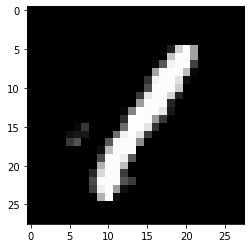

In [70]:
# Denormalizing for visualizing
random_img = train_dataset[201][0].numpy() * stddev_gray + mean_gray
label = train_dataset[201][1]
plt.imshow(random_img.reshape(28,28), cmap = 'gray')
label

In [71]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [72]:
train_dataset[0][1]

5

In [73]:
batch_size = 100

In [74]:
train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                        batch_size = batch_size,
                                        shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                       batch_size = batch_size,
                                       shuffle = False)

In [75]:
len(train_load) # Each batch size

600

In [76]:
len(test_load)

100

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(1568, 600)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(600, 10)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.view(-1, 1568)
        
        out = self.fc1(out)
        out = self.relu(out)
        
        out = self.dropout(out)
        
        out = self.fc2(out)
        return out

In [37]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [38]:
model.parameters

<bound method Module.parameters of CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=600, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)>

In [40]:
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_load):
    print("Input Shape: ", inputs.shape)
    print("Labels Shape: ", labels.shape)
    
    outputs = model(inputs)
    
    print("Outputs Shape: ", outputs.shape)
    
    _, predicted = torch.max(output, 1)
    
    print("Predicted Shape: ", predicted.shape)
    print("Predicted Tensor: ")
    print(predicted)
    
    correct += (predicted == labels).sum()
    break

Input Shape:  torch.Size([100, 1, 28, 28])
Labels Shape:  torch.Size([100])
Outputs Shape:  torch.Size([100, 10])
Predicted Shape:  torch.Size([100])
Predicted Tensor: 
tensor([4, 4, 2, 5, 5, 5, 4, 5, 4, 5, 4, 1, 9, 2, 4, 2, 4, 2, 3, 4, 5, 4, 4, 4,
        4, 4, 4, 4, 5, 2, 4, 4, 2, 0, 4, 0, 2, 4, 4, 5, 4, 5, 5, 1, 4, 4, 5, 5,
        4, 5, 2, 4, 4, 4, 2, 4, 5, 5, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 6, 2,
        2, 4, 2, 2, 5, 4, 4, 4, 2, 5, 4, 2, 5, 5, 9, 2, 4, 4, 4, 6, 4, 5, 4, 4,
        9, 4, 9, 8])


In [48]:
# Training the CNN

epochs = 10
train_loss = []
train_accuracy = []
testing_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train() # This is because we have used batchnorm and dropout as they behave differently in test and train
    for i, (inputs, labels) in enumerate(train_load):
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1) # Returns actual value and index
        correct += (predicted == labels).sum().item()
        
        iterations += 1
        
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100 * correct / len(train_dataset))
    
#     Testing Phase
    test_loss = 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    for i, (inputs, labels) in  enumerate(test_load):
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    testing_loss.append(test_loss/iterations)
    test_accuracy.append(100 * correct / len(test_dataset))
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}, Testing Loss: {testing_loss[-1]:.3f}, Testing Accuracy: {test_accuracy[-1]:.3f}")

Epoch 1/10, Training Loss: 0.078, Training Accuracy: 97.755, Testing Loss: 0.043, Testing Accuracy: 98.870
Epoch 2/10, Training Loss: 0.068, Training Accuracy: 98.092, Testing Loss: 0.044, Testing Accuracy: 98.770
Epoch 3/10, Training Loss: 0.065, Training Accuracy: 98.168, Testing Loss: 0.054, Testing Accuracy: 98.600
Epoch 4/10, Training Loss: 0.061, Training Accuracy: 98.297, Testing Loss: 0.046, Testing Accuracy: 98.790
Epoch 5/10, Training Loss: 0.060, Training Accuracy: 98.317, Testing Loss: 0.042, Testing Accuracy: 99.000
Epoch 6/10, Training Loss: 0.056, Training Accuracy: 98.473, Testing Loss: 0.040, Testing Accuracy: 98.950
Epoch 7/10, Training Loss: 0.056, Training Accuracy: 98.450, Testing Loss: 0.038, Testing Accuracy: 98.930
Epoch 8/10, Training Loss: 0.051, Training Accuracy: 98.558, Testing Loss: 0.041, Testing Accuracy: 98.980
Epoch 9/10, Training Loss: 0.047, Training Accuracy: 98.770, Testing Loss: 0.042, Testing Accuracy: 98.910
Epoch 10/10, Training Loss: 0.049, Tr

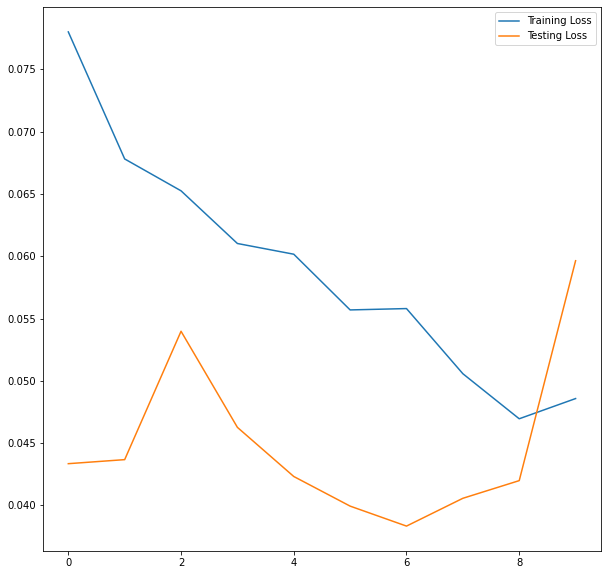

In [49]:
f = plt.figure(figsize = (10, 10))
plt.plot(train_loss, label = 'Training Loss')
plt.plot(testing_loss, label = "Testing Loss")
plt.legend()
plt.show()

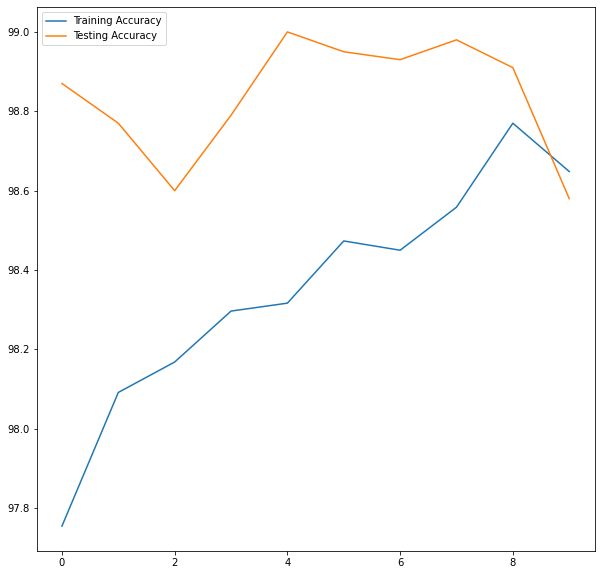

In [50]:
f = plt.figure(figsize = (10, 10))
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(test_accuracy, label = "Testing Accuracy")
plt.legend()
plt.show()

In [64]:
img = test_dataset[100][0].resize_((1, 1, 28, 28))
label = test_dataset[100][1]

In [65]:
model.eval()
outputs = model(img)
_, prediction = torch.max(outputs, 1)
print(f"Prediction: {prediction.item()}")
print(f"Label: {label}")

Prediction: 6
Label: 6
